## Load libraries

In [ ]:
%load_ext autoreload

In [ ]:
%reload_ext XTIPython

In [2]:
%imaris_pull surfaces

['WT Th1  outside CXCL10 cluster',
 'CXCR3 KO Th1 outside CXCL10 cluster',
 'WT Th1  inside CXCL10 cluster',
 'WT Th1 ',
 'CXCL10 cells',
 'WT Th1:CXCL10  contacts',
 'CXCR3 KO Th1 inside CXCL10 cluster',
 'CXCR3 KO Th1']

In [3]:
import Tkinter as tk
import Tkconstants, tkFileDialog

In [5]:
%pylab inline

import pandas as pd
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


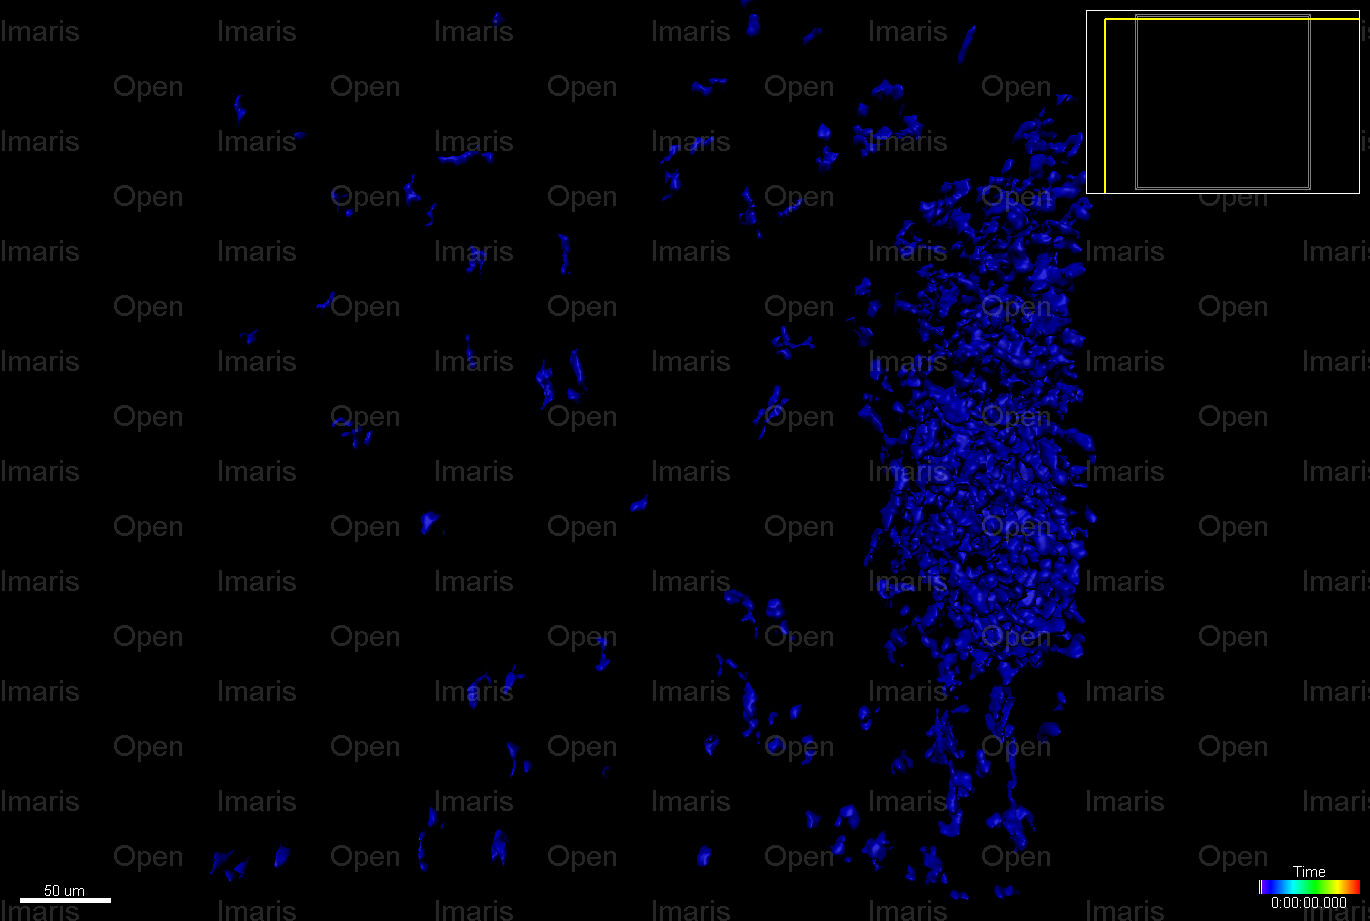

In [6]:
%imaris_screenshot

## Get All Statistics

In [7]:
def get_all_stats(object_type, name):
    
    ## Get object connection for cell collection in Imaris
    
    object_cells = object_type[name]
    object_cell_stats = object_cells.GetStatistics()

    ## Get individual cell IDs and track IDs to create set of edges which form a track
    
    cells = object_cells.GetIds()
    tracks = object_cells.GetTrackIds()
    edges_indices = object_cells.GetTrackEdges()
    edges = [ [str(cells[start]),str(cells[stop])] for [start,stop] in edges_indices]
    
    track_cell_mapping = {}
    for trackID,(start,stop) in zip(tracks,edges_indices):

        start = cells[start]
        stop  = cells[stop]

        track_cell_mapping[str(start)] = str(trackID)
        track_cell_mapping[str(stop)]  = str(trackID)

    track_cell_mapping_df = pd.DataFrame.from_dict(track_cell_mapping,orient='index')
    track_cell_mapping_df.reset_index(inplace=True)
    track_cell_mapping_df.columns = ['objectID','trackID']

    stats_df = pd.DataFrame({'objectID':[str(objid) for objid in object_cell_stats.mIds],
                             'names':object_cell_stats.mNames,
                             'values':object_cell_stats.mValues})

    stats_track_df = pd.merge(left=track_cell_mapping_df,
                              right=stats_df,
                              how='inner')
    
    stats_pivot = stats_track_df.pivot_table(index=['trackID','objectID'],
                                             columns='names',
                                             values='values')
    stats_pivot_df = stats_pivot.reset_index()
    stats_pivot_df['time'] = stats_pivot_df.loc[:,'Time Index']
    
    return(stats_pivot_df)

### Testing

#### Give Object Type

In [8]:
object_type = 'surfaces'

In [9]:
imaris_objects = BridgeLib.GetSurpassObjects(vImaris,object_type)

In [10]:
imaris_objects.keys()

['WT Th1  outside CXCL10 cluster',
 'CXCR3 KO Th1 outside CXCL10 cluster',
 'WT Th1  inside CXCL10 cluster',
 'WT Th1 ',
 'CXCL10 cells',
 'WT Th1:CXCL10  contacts',
 'CXCR3 KO Th1 inside CXCL10 cluster',
 'CXCR3 KO Th1']

#### Give Object Name

In [11]:
object_name = 'CXCL10 cells'

In [12]:
all_stats = get_all_stats(imaris_objects, object_name)

### Push tensor

In [16]:
nx = vDataSet.GetSizeX()
ny = vDataSet.GetSizeY()
nz = vDataSet.GetSizeZ()
nc = vDataSet.GetSizeC()
nt = vDataSet.GetSizeT()

dtype = BridgeLib.GetType(vDataSet)

print nt,nx,ny,nz,nc,dtype

54 512 512 13 7 <type 'numpy.uint16'>


In [17]:
x_min = vDataSet.GetExtendMinX()
x_max = vDataSet.GetExtendMaxX()

y_min = vDataSet.GetExtendMinY()
y_max = vDataSet.GetExtendMaxY()

z_min = vDataSet.GetExtendMinZ()
z_max = vDataSet.GetExtendMaxZ()

In [18]:
x_range = x_max-x_min
y_range = y_max-y_min
z_range = z_max-z_min

x_range,y_range,z_range

(509.11700439453125, 509.11700439453125, 65.0)

In [13]:
columns_to_use = ['trackID','objectID', 'time', 'Position X', 'Position Y', 'Position Z']
data = all_stats.loc[:,columns_to_use].copy()
data.columns = ['trackID','objectID', 'time', 'x', 'y', 'z']

data.head(2)

,trackID,objectID,time,x,y,z
0,1000069538,69538,1.0,500.914917,374.328552,1710.679688
1,1000069538,69961,2.0,501.473053,373.590790,1710.937744


In [14]:
df = data.loc[data.time==1].copy()
df.reset_index(drop=True, inplace=True)

In [19]:
df.head()

,trackID,objectID,time,x,y,z
0,1000069538,69538,1.0,500.914917,374.328552,1710.679688
1,1000069539,69539,1.0,420.003540,374.413391,1714.340698
2,1000069540,69540,1.0,483.163818,377.144226,1714.219971
3,1000069541,69541,1.0,454.700012,388.234741,1714.636597
4,1000069542,69542,1.0,426.296265,283.540009,1687.699097


In [22]:
data_in = BridgeLib.GetDataVolume(vDataSet,aIndexC=3,aIndexT=0)

In [23]:
data_in.shape

(13L, 512L, 512L)

In [24]:
from sklearn.neighbors import kneighbors_graph

In [30]:
network = kneighbors_graph(df.iloc[:,3:], n_neighbors=1)
data_network = network.toarray()